In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기 및 확인

In [20]:
max_reduced10 = pd.read_csv('simulation/camera_10_sim.csv', parse_dates=['_time'], index_col='_time')
max_reduced11 = pd.read_csv('simulation/camera_11_sim.csv', parse_dates=['_time'], index_col='_time')
max_reduced12 = pd.read_csv('simulation/camera_12_sim.csv', parse_dates=['_time'], index_col='_time')
max_reduced14 = pd.read_csv('simulation/camera_14_sim.csv', parse_dates=['_time'], index_col='_time')
max_reduced21 = pd.read_csv('simulation/camera_21_sim.csv', parse_dates=['_time'], index_col='_time')
print(max_reduced10.shape,max_reduced11.shape,max_reduced12.shape,max_reduced14.shape,max_reduced21.shape)
max_reduced10.head(5)

(2880, 1) (2880, 1) (2880, 1) (2880, 1) (2880, 1)


,_value
_time,
2024-09-28 00:00:00+09:00,35.548
2024-09-28 00:01:00+09:00,35.638
2024-09-28 00:02:00+09:00,35.636
2024-09-28 00:03:00+09:00,35.682
2024-09-28 00:04:00+09:00,35.640


## 1번시료

#### 데이터 확인 및 Test구간 설정

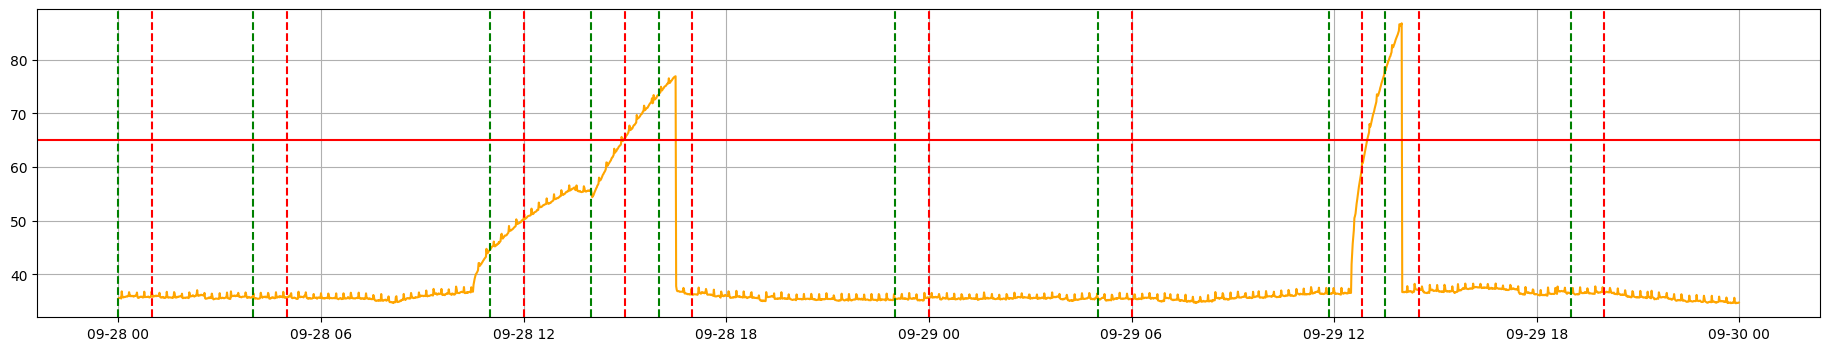

In [21]:
# 다양한 구간을 Test하기 위해 임의로 Test구간 지정(평지구간 5개, 증가구간 3개(2개알람), 급감소구간 2개)
time_ranges = [
    ('2024-09-28 00:00:00+09:00'),
    ('2024-09-28 04:00:00+09:00'),
    ('2024-09-28 11:00:00+09:00'),
    ('2024-09-28 14:00:00+09:00'),
    ('2024-09-28 16:00:00+09:00'),
    ('2024-09-28 23:00:00+09:00'),
    ('2024-09-29 05:00:00+09:00'),
    ('2024-09-29 11:50:00+09:00'),
    ('2024-09-29 13:30:00+09:00'),
    ('2024-09-29 19:00:00+09:00')
]

# 그래프 그리기
plt.figure(figsize=(23, 4))
plt.plot(max_reduced10.index, max_reduced10['_value'], label='use_df (original data)', color='orange')

# 각 time_range의 시작과 끝에 수직선을 그리기
for start in time_ranges:
    start_time = pd.to_datetime(start)
    end_time = start_time + pd.Timedelta(hours=1)  # 학습 시간 구간 설정 (1시간)

    # 시작 시간에 수직선
    plt.axvline(x=start_time, color='green', linestyle='--', label=f'Start: {start}')
    # 끝 시간에 수직선
    plt.axvline(x=end_time, color='red', linestyle='--', label=f'End: {end_time}')
plt.axhline(65, color='red')
plt.grid()
plt.show()

#### Test기간 5분씩 테스트 후 알람확인

In [22]:
results = []

# 각 시간 범위에 대해 슬라이딩 예측 수행
for start in time_ranges:
    start_time = pd.to_datetime(start)
    
    # 5번의 슬라이딩 예측 수행
    for i in range(5):  # 총 5번 예측
        train_start = start_time + pd.Timedelta(minutes=i)  # 시작 시간
        train_end = train_start + pd.Timedelta(hours=1)  # 1시간 후
        
        train_window = max_reduced10.loc[train_start:train_end]  # 해당 시간 구간의 데이터
        
        # ARIMA 모델 학습
        model = ARIMA(train_window, order=(12, 2, 6))
        model_fit = model.fit()
        
        # 30분 예측
        forecast = model_fit.forecast(steps=30)
        forecast_df = pd.DataFrame(forecast)
        forecast_transpose = forecast_df.T
        forecast_transpose.index = [forecast_transpose.columns[0]]
        forecast_transpose.columns = [f'{i}min_later' for i in range(1, len(forecast_transpose.columns) + 1)]
        forecast_transpose['pred_max'] = forecast_transpose.iloc[0].max()
        forecast_transpose['alarm'] = (forecast_transpose.iloc[0] > 65).any()
        results.append(forecast_transpose)

# 결과를 하나의 데이터프레임으로 합치기
results_df = pd.concat(results)
# final_alarm 열 생성
results_df['final_alarm'] = False

# 시간대 그룹핑 및 final_alarm 업데이트
time_bins = pd.date_range(start=results_df.index.min(), end=results_df.index.max(), freq='5T')  # 5분 단위로 그룹핑
for start_time in time_bins:
    end_time = start_time + pd.Timedelta(minutes=5)
    mask = (results_df.index >= start_time) & (results_df.index < end_time)
    
    if mask.any():  # 그룹에 데이터가 있는 경우
        if results_df.loc[mask, 'alarm'].all():  # 모든 alarm이 True인 경우
            results_df.loc[mask, 'final_alarm'] = True

## 결과물 생성
max_reduced10_A = max_reduced10.copy()

#실제 값에서부터 30분 미래까지의 최대값 확인
max_reduced10_A['real_max'] = max_reduced10_A['_value'][::-1].rolling(window=30, min_periods=1).max()[::-1]
max_reduced10_A.fillna(0,inplace=True)

#30분 미래값에서 65를 넘는값이 있다면 비정상으로 확인
max_reduced10_A['abnormal'] = (max_reduced10_A['real_max'] > 65)
max_reduced10_A['abnormal'].fillna(False, inplace=True)

#30분 미래값, 실제 비정상여부, 알람여부 확인
merged_df10 = results_df.merge(max_reduced10_A[['real_max','abnormal']], left_index=True, right_index=True, how='left')
merged_df10['result']= merged_df10['abnormal']==merged_df10['final_alarm']
merged_df10.to_csv('result/camera_10_sim.csv')
merged_df10[merged_df10['result']==True].shape[0]/merged_df10.shape[0]

1.0

#### 예측성능 확인

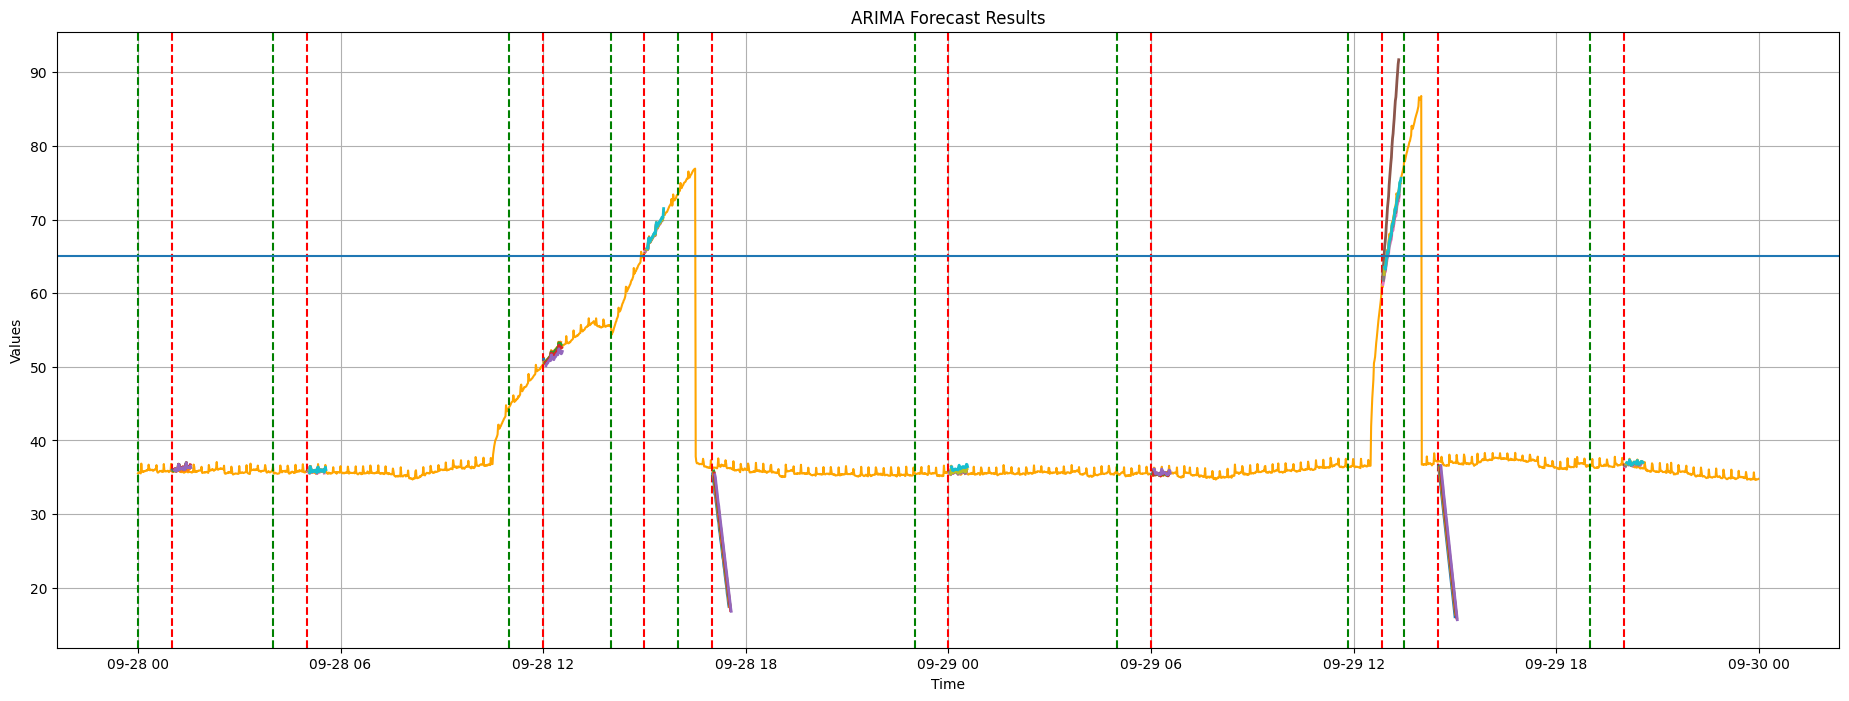

In [23]:
# 그래프 그리기
plt.figure(figsize=(23, 8))
plt.plot(max_reduced10.index, max_reduced10['_value'], label='max_reduced10 (original data)', color='orange')

# 각 time_range의 시작과 끝에 수직선을 그리기
for start in time_ranges:
    start_time = pd.to_datetime(start)
    end_time = start_time + pd.Timedelta(hours=1)  # 학습 시간 구간 설정 (1시간)
    
    # 시작 시간에 수직선
    plt.axvline(x=start_time, color='green', linestyle='--', label=f'Start: {start}')
    # 끝 시간에 수직선
    plt.axvline(x=end_time, color='red', linestyle='--', label=f'End: {end_time}')

# 예측 결과 플로팅
for i, result in enumerate(results):
    forecast_start_time = result.index[0]  # 예측 시작 시간
    forecast_values = result.iloc[0, :-2]  # 예측된 값 (마지막 열은 'alarm'임)
    forecast_index = pd.date_range(start=forecast_start_time, periods=len(forecast_values), freq='T')
    
    plt.plot(forecast_index, forecast_values, label=f'Forecast {i + 1}', linestyle='-', linewidth=2)

plt.axhline(65)
plt.grid()
plt.title('ARIMA Forecast Results')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()


## 2번시료

#### 데이터 확인 및 Test구간 설정

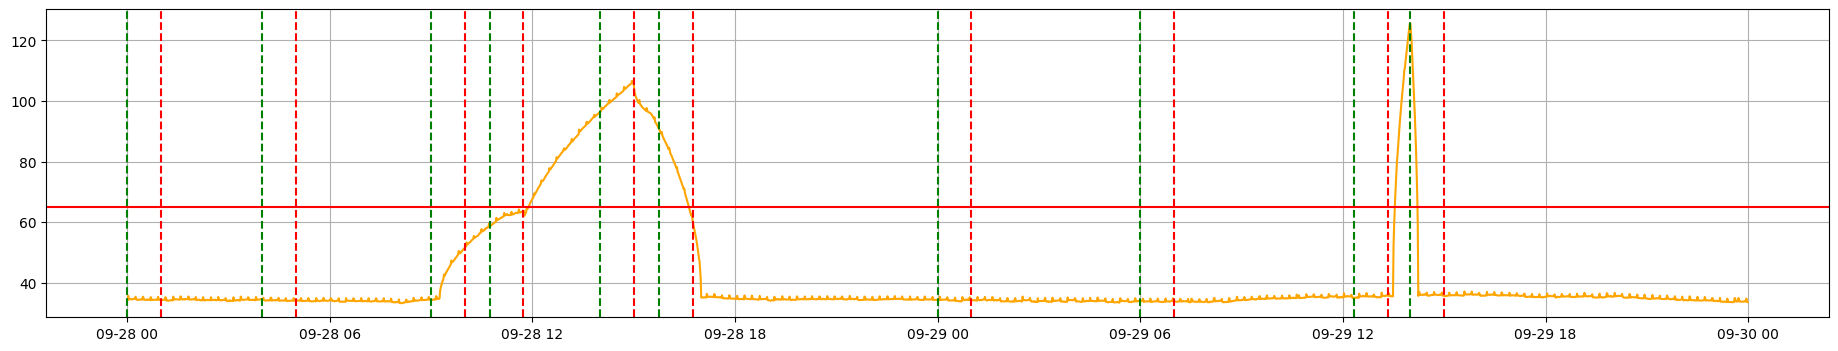

In [6]:
# 다양한 구간을 Test하기 위해 임의로 Test구간 지정(평지구간 5개, 증가구간 3개(2개알람), 급감소구간 2개)
time_ranges = [
    ('2024-09-28 00:00:00+09:00'),
    ('2024-09-28 04:00:00+09:00'),
    ('2024-09-28 09:00:00+09:00'),
    ('2024-09-28 10:44:00+09:00'),
    ('2024-09-28 14:00:00+09:00'),
    ('2024-09-28 15:45:00+09:00'),
    ('2024-09-29 00:00:00+09:00'),
    ('2024-09-29 06:00:00+09:00'),
    ('2024-09-29 12:20:00+09:00'),
    ('2024-09-29 14:00:00+09:00')
]

# 그래프 그리기
plt.figure(figsize=(23, 4))
plt.plot(max_reduced11.index, max_reduced11['_value'], label='use_df (original data)', color='orange')

# 각 time_range의 시작과 끝에 수직선을 그리기
for start in time_ranges:
    start_time = pd.to_datetime(start)
    end_time = start_time + pd.Timedelta(hours=1)  # 학습 시간 구간 설정 (1시간)

    # 시작 시간에 수직선
    plt.axvline(x=start_time, color='green', linestyle='--', label=f'Start: {start}')
    # 끝 시간에 수직선
    plt.axvline(x=end_time, color='red', linestyle='--', label=f'End: {end_time}')
plt.axhline(65, color='red')
plt.grid()
plt.show()

#### Test기간 5분씩 테스트 후 알람확인

In [7]:
results = []

# 각 시간 범위에 대해 슬라이딩 예측 수행
for start in time_ranges:
    start_time = pd.to_datetime(start)
    
    # 5번의 슬라이딩 예측 수행
    for i in range(5):  # 총 5번 예측
        train_start = start_time + pd.Timedelta(minutes=i)  # 시작 시간
        train_end = train_start + pd.Timedelta(hours=1)  # 1시간 후
        
        train_window = max_reduced11.loc[train_start:train_end]  # 해당 시간 구간의 데이터
        
        # ARIMA 모델 학습
        model = ARIMA(train_window, order=(12, 2, 6))
        model_fit = model.fit()
        
        # 30분 예측
        forecast = model_fit.forecast(steps=30)
        forecast_df = pd.DataFrame(forecast)
        forecast_transpose = forecast_df.T
        forecast_transpose.index = [forecast_transpose.columns[0]]
        forecast_transpose.columns = [f'{i}min_later' for i in range(1, len(forecast_transpose.columns) + 1)]
        forecast_transpose['pred_max'] = forecast_transpose.iloc[0].max()
        forecast_transpose['alarm'] = (forecast_transpose.iloc[0] > 65).any()
        results.append(forecast_transpose)

# 결과를 하나의 데이터프레임으로 합치기
results_df = pd.concat(results)
# final_alarm 열 생성
results_df['final_alarm'] = False

# 시간대 그룹핑 및 final_alarm 업데이트
time_bins = pd.date_range(start=results_df.index.min(), end=results_df.index.max(), freq='5T')  # 5분 단위로 그룹핑
for start_time in time_bins:
    end_time = start_time + pd.Timedelta(minutes=5)
    mask = (results_df.index >= start_time) & (results_df.index < end_time)
    
    if mask.any():  # 그룹에 데이터가 있는 경우
        if results_df.loc[mask, 'alarm'].all():  # 모든 alarm이 True인 경우
            results_df.loc[mask, 'final_alarm'] = True

## 결과물 생성
max_reduced11_A = max_reduced11.copy()

#실제 값에서부터 30분 미래까지의 최대값 확인
max_reduced11_A['real_max'] = max_reduced11_A['_value'][::-1].rolling(window=30, min_periods=1).max()[::-1]
max_reduced11_A.fillna(0,inplace=True)

#30분 미래값에서 65를 넘는값이 있다면 비정상으로 확인
max_reduced11_A['abnormal'] = (max_reduced11_A['real_max'] > 65)
max_reduced11_A['abnormal'].fillna(False, inplace=True)

#30분 미래값, 실제 비정상여부, 알람여부 확인
merged_df11 = results_df.merge(max_reduced11_A[['real_max','abnormal']], left_index=True, right_index=True, how='left')
merged_df11['result']= merged_df11['abnormal']==merged_df11['final_alarm']
merged_df11.to_csv('result/camera_11_sim.csv')
merged_df11[merged_df11['result']==True].shape[0]/merged_df11.shape[0]

0.8

#### 예측성능 확인


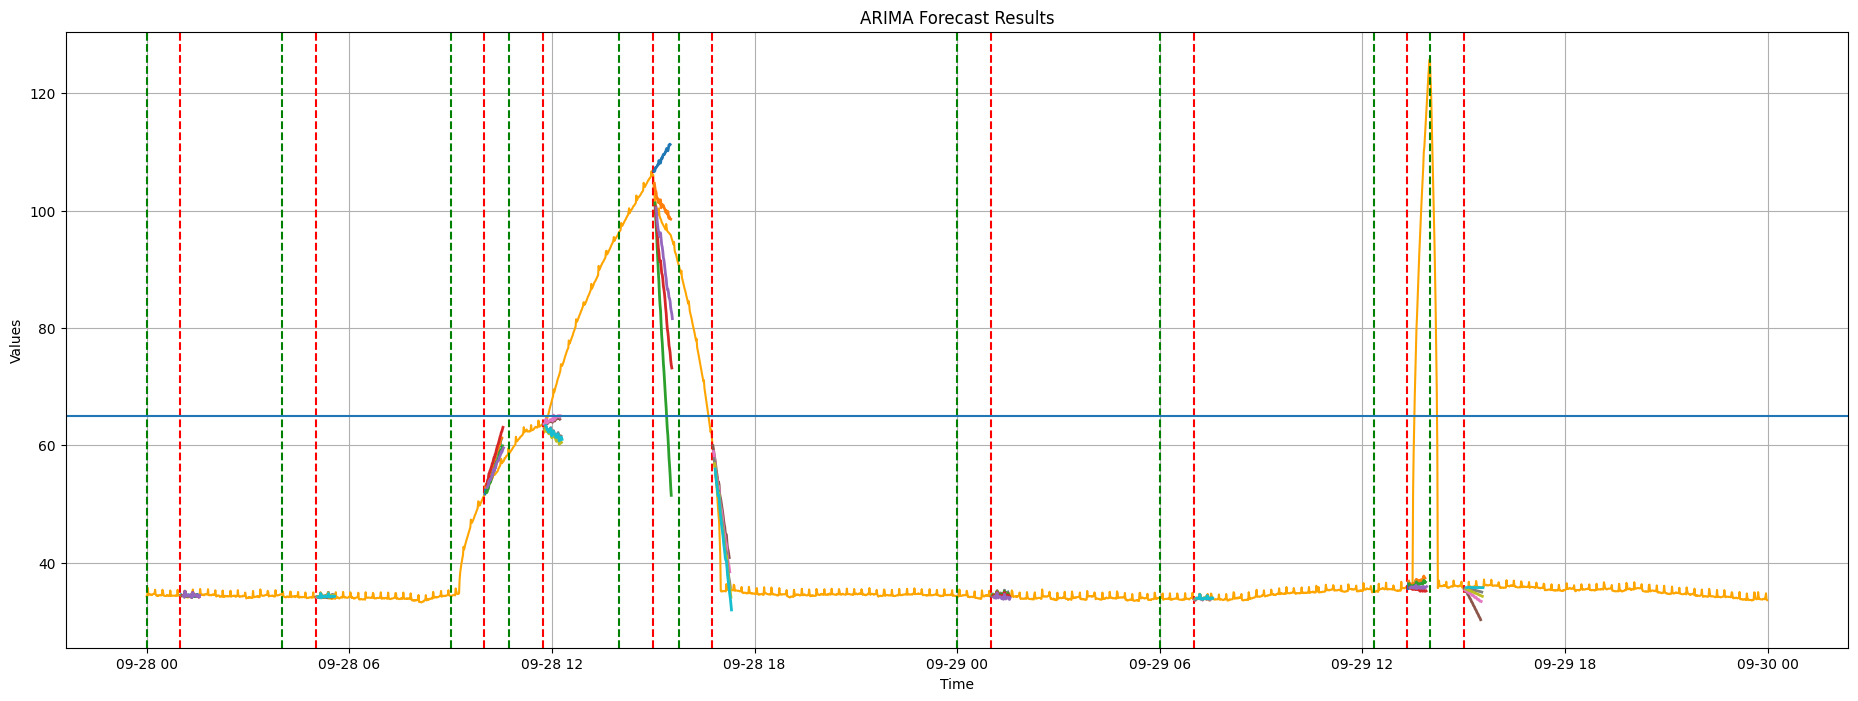

In [8]:
# 그래프 그리기
plt.figure(figsize=(23, 8))
plt.plot(max_reduced11.index, max_reduced11['_value'], label='max_reduced11 (original data)', color='orange')

# 각 time_range의 시작과 끝에 수직선을 그리기
for start in time_ranges:
    start_time = pd.to_datetime(start)
    end_time = start_time + pd.Timedelta(hours=1)  # 학습 시간 구간 설정 (1시간)
    
    # 시작 시간에 수직선
    plt.axvline(x=start_time, color='green', linestyle='--', label=f'Start: {start}')
    # 끝 시간에 수직선
    plt.axvline(x=end_time, color='red', linestyle='--', label=f'End: {end_time}')

# 예측 결과 플로팅
for i, result in enumerate(results):
    forecast_start_time = result.index[0]  # 예측 시작 시간
    forecast_values = result.iloc[0, :-2]  # 예측된 값 (마지막 열은 'alarm'임)
    forecast_index = pd.date_range(start=forecast_start_time, periods=len(forecast_values), freq='T')
    
    plt.plot(forecast_index, forecast_values, label=f'Forecast {i + 1}', linestyle='-', linewidth=2)

plt.axhline(65)
plt.grid()
plt.title('ARIMA Forecast Results')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()


## 3번시료

#### 데이터 확인 및 Test구간 설정

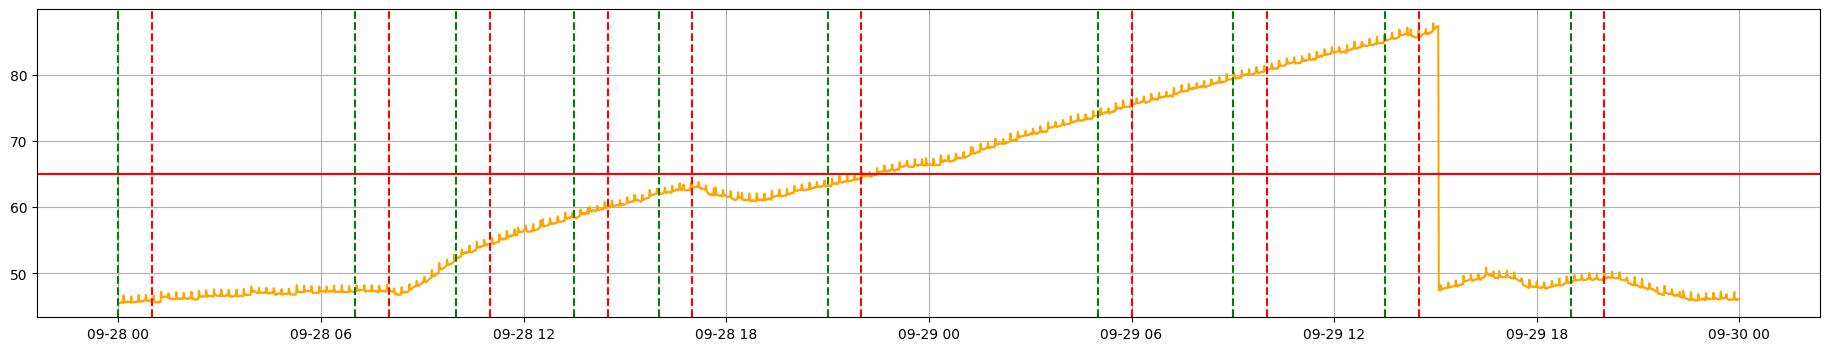

In [9]:
# 다양한 구간을 Test하기 위해 임의로 Test구간 지정(평지구간 3개, 증가구간 7개(4개만 알람되야함))
time_ranges = [
    ('2024-09-28 00:00:00+09:00'),
    ('2024-09-28 07:00:00+09:00'),
    ('2024-09-28 10:00:00+09:00'),
    ('2024-09-28 13:30:00+09:00'),
    ('2024-09-28 16:00:00+09:00'),
    ('2024-09-28 21:00:00+09:00'),
    ('2024-09-29 05:00:00+09:00'),
    ('2024-09-29 09:00:00+09:00'),
    ('2024-09-29 13:30:00+09:00'),
    ('2024-09-29 19:00:00+09:00')
]

# 그래프 그리기
plt.figure(figsize=(23, 4))
plt.plot(max_reduced12.index, max_reduced12['_value'], label='use_df (original data)', color='orange')

# 각 time_range의 시작과 끝에 수직선을 그리기
for start in time_ranges:
    start_time = pd.to_datetime(start)
    end_time = start_time + pd.Timedelta(hours=1)  # 학습 시간 구간 설정 (1시간)

    # 시작 시간에 수직선
    plt.axvline(x=start_time, color='green', linestyle='--', label=f'Start: {start}')
    # 끝 시간에 수직선
    plt.axvline(x=end_time, color='red', linestyle='--', label=f'End: {end_time}')
plt.axhline(65, color='red')
plt.grid()
plt.show()

#### Test기간 5분씩 테스트 후 알람확인

In [10]:
results = []

# 각 시간 범위에 대해 슬라이딩 예측 수행
for start in time_ranges:
    start_time = pd.to_datetime(start)
    
    # 5번의 슬라이딩 예측 수행
    for i in range(5):  # 총 5번 예측
        train_start = start_time + pd.Timedelta(minutes=i)  # 시작 시간
        train_end = train_start + pd.Timedelta(hours=1)  # 1시간 후
        
        train_window = max_reduced12.loc[train_start:train_end]  # 해당 시간 구간의 데이터
        
        # ARIMA 모델 학습
        model = ARIMA(train_window, order=(12, 2, 6))
        model_fit = model.fit()
        
        # 30분 예측
        forecast = model_fit.forecast(steps=30)
        forecast_df = pd.DataFrame(forecast)
        forecast_transpose = forecast_df.T
        forecast_transpose.index = [forecast_transpose.columns[0]]
        forecast_transpose.columns = [f'{i}min_later' for i in range(1, len(forecast_transpose.columns) + 1)]
        forecast_transpose['pred_max'] = forecast_transpose.iloc[0].max()
        forecast_transpose['alarm'] = (forecast_transpose.iloc[0] > 65).any()
        results.append(forecast_transpose)

# 결과를 하나의 데이터프레임으로 합치기
results_df = pd.concat(results)
# final_alarm 열 생성
results_df['final_alarm'] = False

# 시간대 그룹핑 및 final_alarm 업데이트
time_bins = pd.date_range(start=results_df.index.min(), end=results_df.index.max(), freq='5T')  # 5분 단위로 그룹핑
for start_time in time_bins:
    end_time = start_time + pd.Timedelta(minutes=5)
    mask = (results_df.index >= start_time) & (results_df.index < end_time)
    
    if mask.any():  # 그룹에 데이터가 있는 경우
        if results_df.loc[mask, 'alarm'].all():  # 모든 alarm이 True인 경우
            results_df.loc[mask, 'final_alarm'] = True

## 결과물 생성
max_reduced12_A = max_reduced12.copy()

#실제 값에서부터 30분 미래까지의 최대값 확인
max_reduced12_A['real_max'] = max_reduced12_A['_value'][::-1].rolling(window=30, min_periods=1).max()[::-1]
max_reduced12_A.fillna(0,inplace=True)

#30분 미래값에서 65를 넘는값이 있다면 비정상으로 확인
max_reduced12_A['abnormal'] = (max_reduced12_A['real_max'] > 65)
max_reduced12_A['abnormal'].fillna(False, inplace=True)

#30분 미래값, 실제 비정상여부, 알람여부 확인
merged_df12 = results_df.merge(max_reduced12_A[['real_max','abnormal']], left_index=True, right_index=True, how='left')
merged_df12['result']= merged_df12['abnormal']==merged_df12['final_alarm']
merged_df12.to_csv('result/camera_12_sim.csv')
merged_df12[merged_df12['result']==True].shape[0]/merged_df12.shape[0]

1.0

#### 예측성능 확인

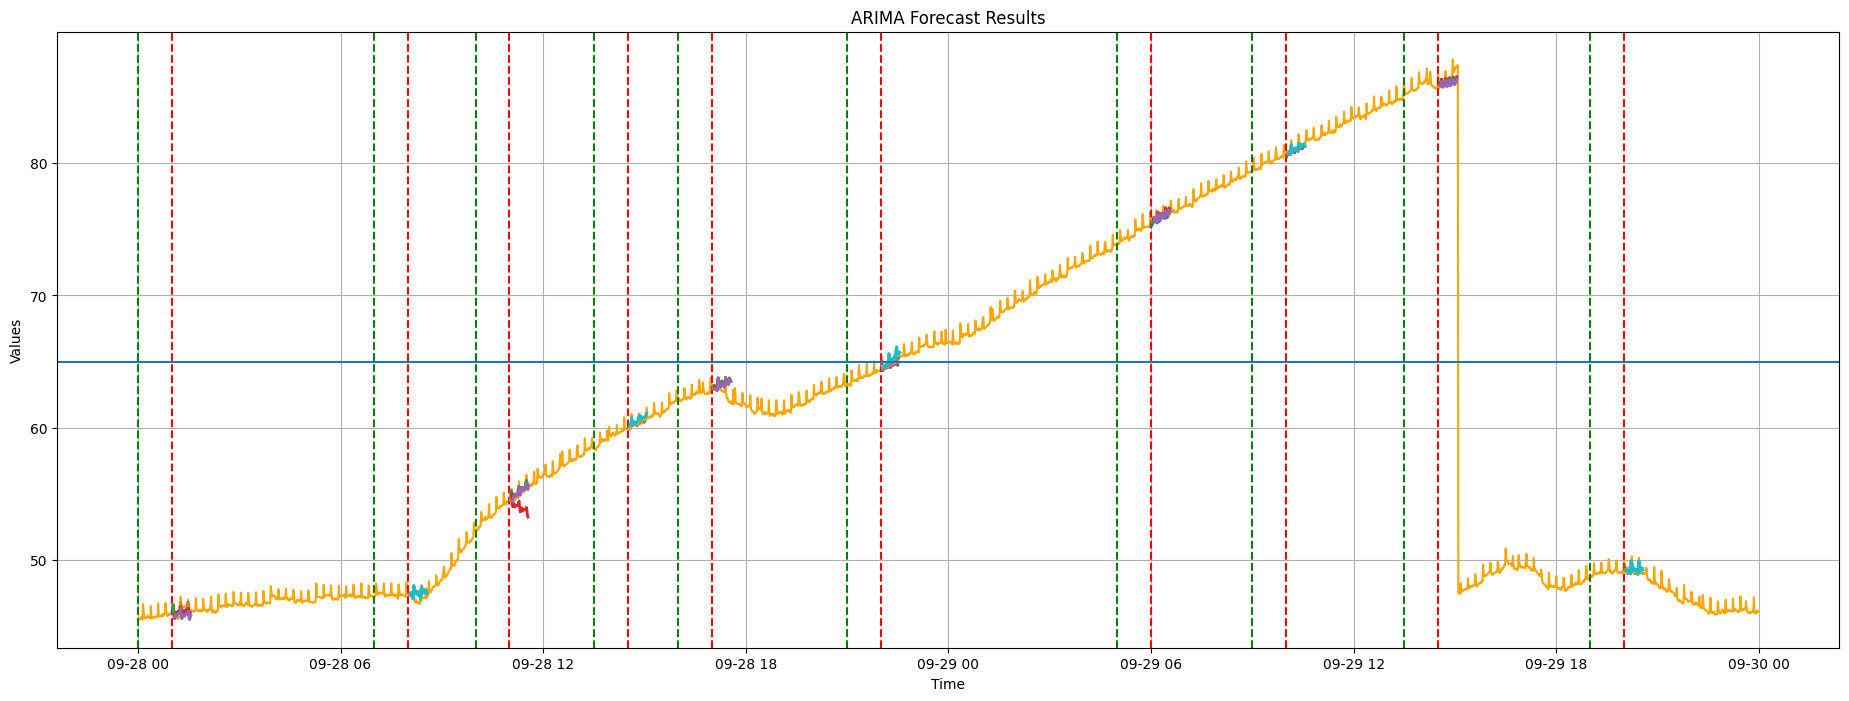

In [11]:
# 그래프 그리기
plt.figure(figsize=(23, 8))
plt.plot(max_reduced12.index, max_reduced12['_value'], label='max_reduced12 (original data)', color='orange')

# 각 time_range의 시작과 끝에 수직선을 그리기
for start in time_ranges:
    start_time = pd.to_datetime(start)
    end_time = start_time + pd.Timedelta(hours=1)  # 학습 시간 구간 설정 (1시간)
    
    # 시작 시간에 수직선
    plt.axvline(x=start_time, color='green', linestyle='--', label=f'Start: {start}')
    # 끝 시간에 수직선
    plt.axvline(x=end_time, color='red', linestyle='--', label=f'End: {end_time}')

# 예측 결과 플로팅
for i, result in enumerate(results):
    forecast_start_time = result.index[0]  # 예측 시작 시간
    forecast_values = result.iloc[0, :-2]  # 예측된 값 (마지막 열은 'alarm'임)
    forecast_index = pd.date_range(start=forecast_start_time, periods=len(forecast_values), freq='T')
    
    plt.plot(forecast_index, forecast_values, label=f'Forecast {i + 1}', linestyle='-', linewidth=2)

plt.axhline(65)
plt.grid()
plt.title('ARIMA Forecast Results')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()


## 4번시료

#### 데이터 확인 및 Test구간 설정

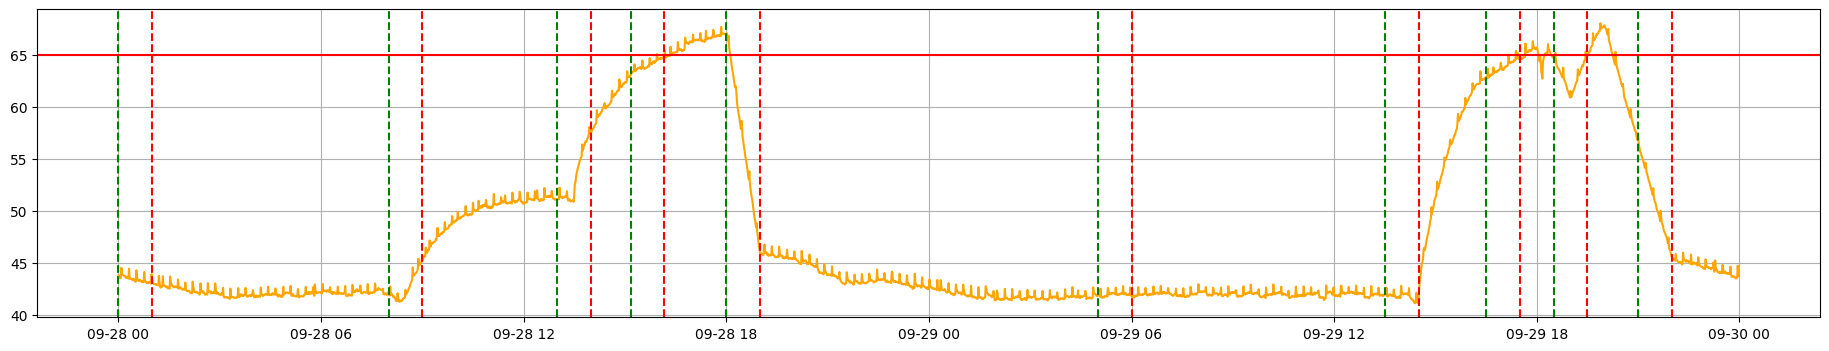

In [12]:
# 다양한 구간을 Test하기 위해 임의로 Test구간 지정(평지구간 3개, 증가구간 5개(3개만 알람되야함), 급감소구간 2개)
time_ranges = [
    ('2024-09-28 00:00:00+09:00'),
    ('2024-09-28 08:00:00+09:00'),
    ('2024-09-28 13:00:00+09:00'),
    ('2024-09-28 15:10:00+09:00'),
    ('2024-09-28 18:00:00+09:00'),
    ('2024-09-29 05:00:00+09:00'),
    ('2024-09-29 13:30:00+09:00'),
    ('2024-09-29 16:30:00+09:00'),
    ('2024-09-29 18:30:00+09:00'),
    ('2024-09-29 21:00:00+09:00'),
]

# 그래프 그리기
plt.figure(figsize=(23, 4))
plt.plot(max_reduced14.index, max_reduced14['_value'], label='use_df (original data)', color='orange')

# 각 time_range의 시작과 끝에 수직선을 그리기
for start in time_ranges:
    start_time = pd.to_datetime(start)
    end_time = start_time + pd.Timedelta(hours=1)  # 학습 시간 구간 설정 (1시간)

    # 시작 시간에 수직선
    plt.axvline(x=start_time, color='green', linestyle='--', label=f'Start: {start}')
    # 끝 시간에 수직선
    plt.axvline(x=end_time, color='red', linestyle='--', label=f'End: {end_time}')
plt.axhline(65, color='red')
plt.grid()
plt.show()

#### Test기간 5분씩 테스트 후 알림확인

In [13]:
results = []

# 각 시간 범위에 대해 슬라이딩 예측 수행
for start in time_ranges:
    start_time = pd.to_datetime(start)
    
    # 5번의 슬라이딩 예측 수행
    for i in range(5):  # 총 5번 예측
        train_start = start_time + pd.Timedelta(minutes=i)  # 시작 시간
        train_end = train_start + pd.Timedelta(hours=1)  # 1시간 후
        
        train_window = max_reduced14.loc[train_start:train_end]  # 해당 시간 구간의 데이터
        
        # ARIMA 모델 학습
        model = ARIMA(train_window, order=(12, 2, 6))
        model_fit = model.fit()
        
        # 30분 예측
        forecast = model_fit.forecast(steps=30)
        forecast_df = pd.DataFrame(forecast)
        forecast_transpose = forecast_df.T
        forecast_transpose.index = [forecast_transpose.columns[0]]
        forecast_transpose.columns = [f'{i}min_later' for i in range(1, len(forecast_transpose.columns) + 1)]
        forecast_transpose['pred_max'] = forecast_transpose.iloc[0].max()
        forecast_transpose['alarm'] = (forecast_transpose.iloc[0] > 65).any()
        results.append(forecast_transpose)

# 결과를 하나의 데이터프레임으로 합치기
results_df = pd.concat(results)
# final_alarm 열 생성
results_df['final_alarm'] = False

# 시간대 그룹핑 및 final_alarm 업데이트
time_bins = pd.date_range(start=results_df.index.min(), end=results_df.index.max(), freq='5T')  # 5분 단위로 그룹핑
for start_time in time_bins:
    end_time = start_time + pd.Timedelta(minutes=5)
    mask = (results_df.index >= start_time) & (results_df.index < end_time)
    
    if mask.any():  # 그룹에 데이터가 있는 경우
        if results_df.loc[mask, 'alarm'].all():  # 모든 alarm이 True인 경우
            results_df.loc[mask, 'final_alarm'] = True

## 결과물 생성
max_reduced14_A = max_reduced14.copy()

#실제 값에서부터 30분 미래까지의 최대값 확인
max_reduced14_A['real_max'] = max_reduced14_A['_value'][::-1].rolling(window=30, min_periods=1).max()[::-1]
max_reduced14_A.fillna(0,inplace=True)

#30분 미래값에서 65를 넘는값이 있다면 비정상으로 확인
max_reduced14_A['abnormal'] = (max_reduced14_A['real_max'] > 65)
max_reduced14_A['abnormal'].fillna(False, inplace=True)

#30분 미래값, 실제 비정상여부, 알람여부 확인
merged_df14 = results_df.merge(max_reduced14_A[['real_max','abnormal']], left_index=True, right_index=True, how='left')
merged_df14['result']= merged_df14['abnormal']==merged_df14['final_alarm']
merged_df14.to_csv('result/camera_14_sim.csv')
merged_df14[merged_df14['result']==True].shape[0]/merged_df14.shape[0]

1.0

#### 예측성능 확인

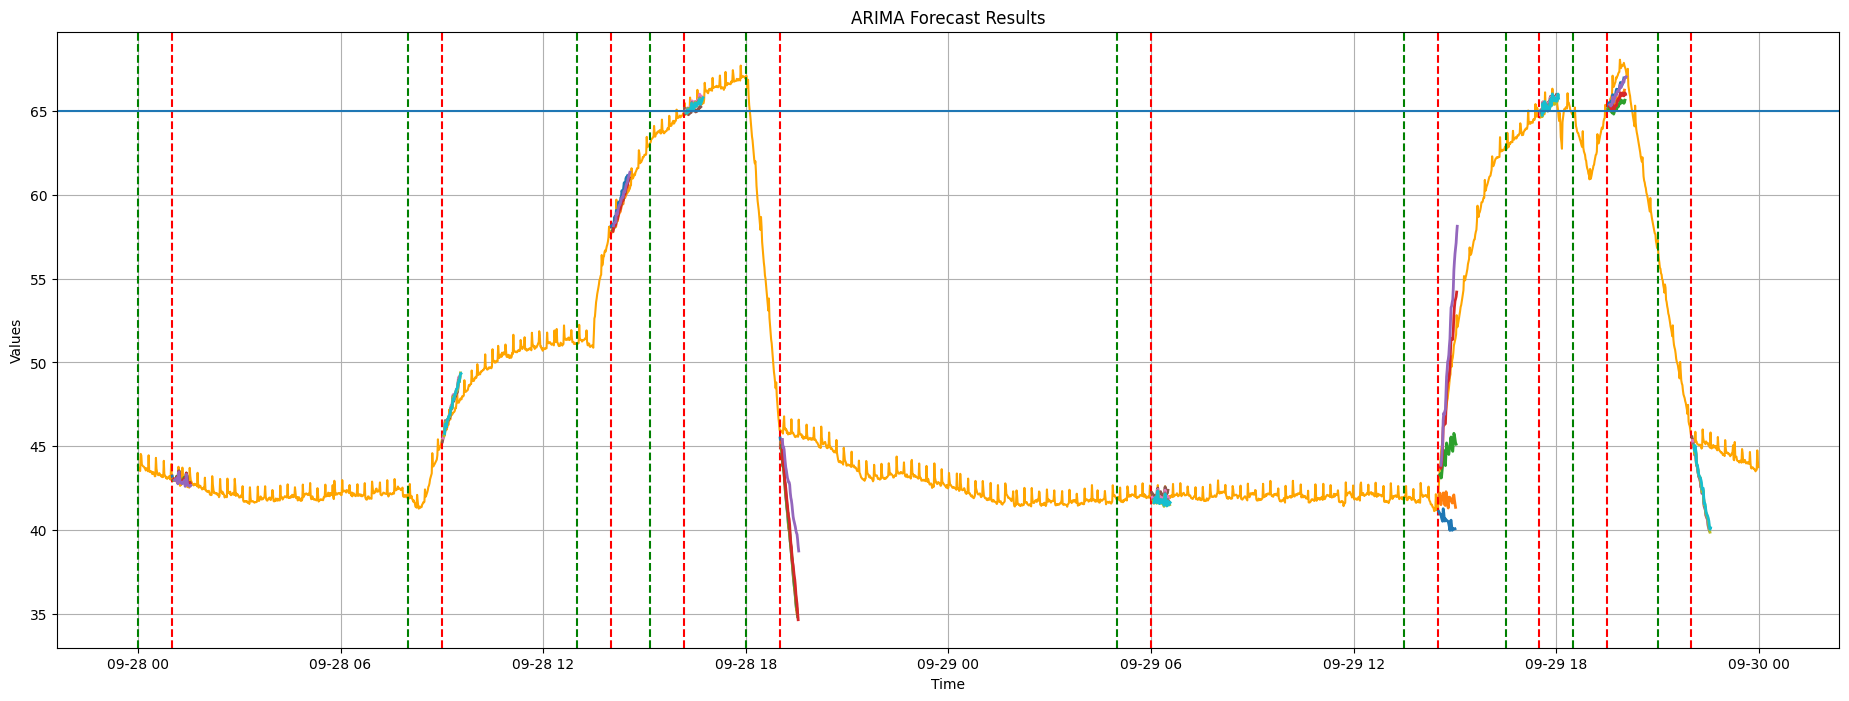

In [14]:
# 그래프 그리기
plt.figure(figsize=(23, 8))
plt.plot(max_reduced14.index, max_reduced14['_value'], label='max_reduced14 (original data)', color='orange')

# 각 time_range의 시작과 끝에 수직선을 그리기
for start in time_ranges:
    start_time = pd.to_datetime(start)
    end_time = start_time + pd.Timedelta(hours=1)  # 학습 시간 구간 설정 (1시간)
    
    # 시작 시간에 수직선
    plt.axvline(x=start_time, color='green', linestyle='--', label=f'Start: {start}')
    # 끝 시간에 수직선
    plt.axvline(x=end_time, color='red', linestyle='--', label=f'End: {end_time}')

# 예측 결과 플로팅
for i, result in enumerate(results):
    forecast_start_time = result.index[0]  # 예측 시작 시간
    forecast_values = result.iloc[0, :-2]  # 예측된 값 (마지막 열은 'alarm'임)
    forecast_index = pd.date_range(start=forecast_start_time, periods=len(forecast_values), freq='T')
    
    plt.plot(forecast_index, forecast_values, label=f'Forecast {i + 1}', linestyle='-', linewidth=2)

plt.axhline(65)
plt.grid()
plt.title('ARIMA Forecast Results')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()


## 5번시료

#### 데이터 확인 및 Test구간 설정

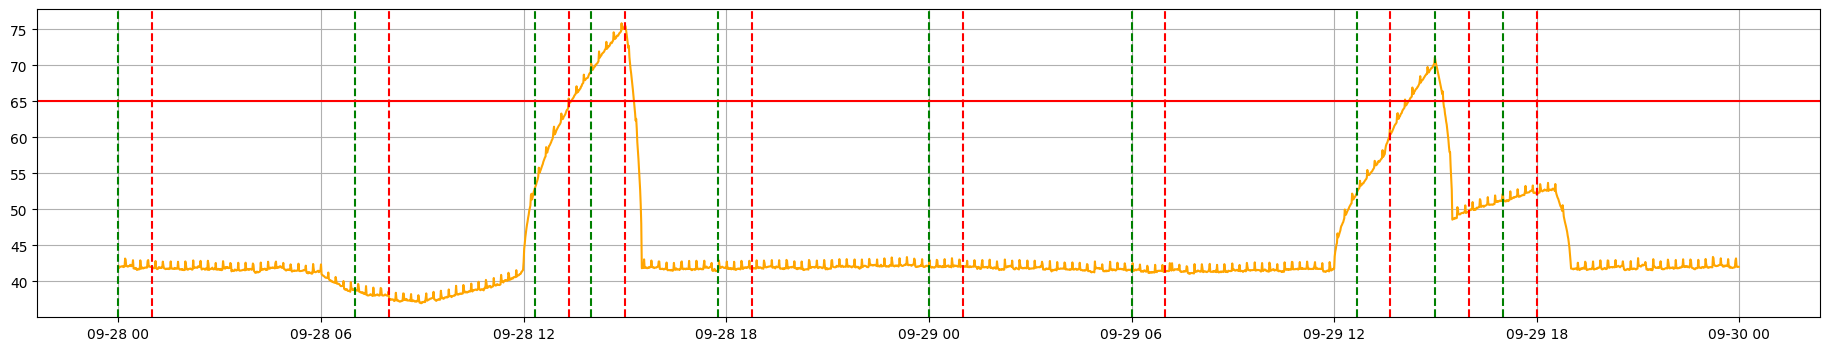

In [15]:
# 다양한 구간을 Test하기 위해 임의로 Test구간 지정(평지구간 5개, 증가구간 5개(3개만 알람되야함))
time_ranges = [
    ('2024-09-28 00:00:00+09:00'),
    ('2024-09-28 07:00:00+09:00'),
    ('2024-09-28 12:20:00+09:00'),
    ('2024-09-28 14:00:00+09:00'),
    ('2024-09-28 17:45:00+09:00'),
    ('2024-09-29 00:00:00+09:00'),
    ('2024-09-29 06:00:00+09:00'),
    ('2024-09-29 12:40:00+09:00'),
    ('2024-09-29 15:00:00+09:00'),
    ('2024-09-29 17:00:00+09:00'),
]

# 그래프 그리기
plt.figure(figsize=(23, 4))
plt.plot(max_reduced21.index, max_reduced21['_value'], label='use_df (original data)', color='orange')

# 각 time_range의 시작과 끝에 수직선을 그리기
for start in time_ranges:
    start_time = pd.to_datetime(start)
    end_time = start_time + pd.Timedelta(hours=1)  # 학습 시간 구간 설정 (1시간)

    # 시작 시간에 수직선
    plt.axvline(x=start_time, color='green', linestyle='--', label=f'Start: {start}')
    # 끝 시간에 수직선
    plt.axvline(x=end_time, color='red', linestyle='--', label=f'End: {end_time}')
plt.axhline(65, color='red')
plt.grid()
plt.show()

#### Test기간 5분씩 테스트 후 알람확인

In [16]:
results = []

# 각 시간 범위에 대해 슬라이딩 예측 수행
for start in time_ranges:
    start_time = pd.to_datetime(start)
    
    # 5번의 슬라이딩 예측 수행
    for i in range(5):  # 총 5번 예측
        train_start = start_time + pd.Timedelta(minutes=i)  # 시작 시간
        train_end = train_start + pd.Timedelta(hours=1)  # 1시간 후
        
        train_window = max_reduced21.loc[train_start:train_end]  # 해당 시간 구간의 데이터
        
        # ARIMA 모델 학습
        model = ARIMA(train_window, order=(12, 2, 6))
        model_fit = model.fit()
        
        # 30분 예측
        forecast = model_fit.forecast(steps=30)
        forecast_df = pd.DataFrame(forecast)
        forecast_transpose = forecast_df.T
        forecast_transpose.index = [forecast_transpose.columns[0]]
        forecast_transpose.columns = [f'{i}min_later' for i in range(1, len(forecast_transpose.columns) + 1)]
        forecast_transpose['pred_max'] = forecast_transpose.iloc[0].max()
        forecast_transpose['alarm'] = (forecast_transpose.iloc[0] > 65).any()
        results.append(forecast_transpose)

# 결과를 하나의 데이터프레임으로 합치기
results_df = pd.concat(results)
# final_alarm 열 생성
results_df['final_alarm'] = False

# 시간대 그룹핑 및 final_alarm 업데이트
time_bins = pd.date_range(start=results_df.index.min(), end=results_df.index.max(), freq='5T')  # 5분 단위로 그룹핑
for start_time in time_bins:
    end_time = start_time + pd.Timedelta(minutes=5)
    mask = (results_df.index >= start_time) & (results_df.index < end_time)
    
    if mask.any():  # 그룹에 데이터가 있는 경우
        if results_df.loc[mask, 'alarm'].all():  # 모든 alarm이 True인 경우
            results_df.loc[mask, 'final_alarm'] = True

## 결과물 생성
max_reduced21_A = max_reduced21.copy()

#실제 값에서부터 30분 미래까지의 최대값 확인
max_reduced21_A['real_max'] = max_reduced21_A['_value'][::-1].rolling(window=30, min_periods=1).max()[::-1]
max_reduced21_A.fillna(0,inplace=True)

#30분 미래값에서 65를 넘는값이 있다면 비정상으로 확인
max_reduced21_A['abnormal'] = (max_reduced21_A['real_max'] > 65)
max_reduced21_A['abnormal'].fillna(False, inplace=True)

#30분 미래값, 실제 비정상여부, 알람여부 확인
merged_df21 = results_df.merge(max_reduced21_A[['real_max','abnormal']], left_index=True, right_index=True, how='left')
merged_df21['result']= merged_df21['abnormal']==merged_df21['final_alarm']
merged_df21.to_csv('result/camera_21_sim.csv')
merged_df21[merged_df21['result']==True].shape[0]/merged_df21.shape[0]

1.0

#### 예측성능 확인

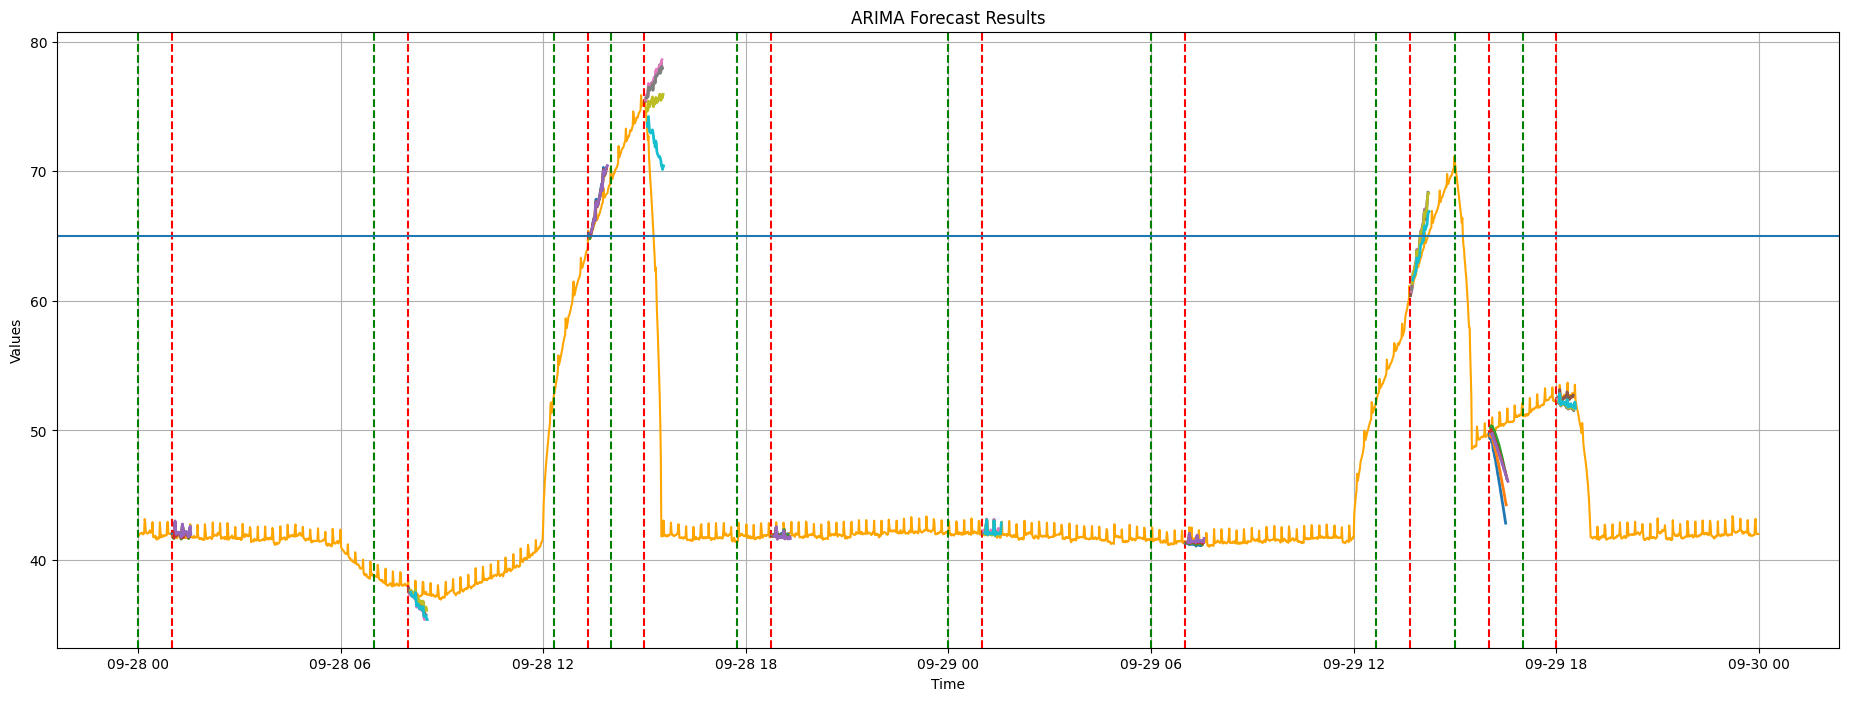

In [17]:
# 그래프 그리기
plt.figure(figsize=(23, 8))
plt.plot(max_reduced21.index, max_reduced21['_value'], label='max_reduced21 (original data)', color='orange')

# 각 time_range의 시작과 끝에 수직선을 그리기
for start in time_ranges:
    start_time = pd.to_datetime(start)
    end_time = start_time + pd.Timedelta(hours=1)  # 학습 시간 구간 설정 (1시간)
    
    # 시작 시간에 수직선
    plt.axvline(x=start_time, color='green', linestyle='--', label=f'Start: {start}')
    # 끝 시간에 수직선
    plt.axvline(x=end_time, color='red', linestyle='--', label=f'End: {end_time}')

# 예측 결과 플로팅
for i, result in enumerate(results):
    forecast_start_time = result.index[0]  # 예측 시작 시간
    forecast_values = result.iloc[0, :-2]  # 예측된 값 (마지막 열은 'alarm'임)
    forecast_index = pd.date_range(start=forecast_start_time, periods=len(forecast_values), freq='T')
    
    plt.plot(forecast_index, forecast_values, label=f'Forecast {i + 1}', linestyle='-', linewidth=2)

plt.axhline(65)
plt.grid()
plt.title('ARIMA Forecast Results')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()


## 전체 결과 확인

In [18]:
total_result = pd.concat([merged_df10,merged_df11,merged_df12,merged_df14,merged_df21],axis=0)
total_result[total_result['result']==True].shape[0]/total_result.shape[0]

0.96